In [94]:
import sys
sys.path.insert(0, "../../scripts")
import dataloader as dl

# Imports

import torchaudio
import numpy as np
from matplotlib import pyplot as plt
import librosa
import os, sys
import pandas as pd

import re

from pathlib import Path
from glob import glob
from typing import Literal
import itertools
import csv
from collections import Counter


from pydub import AudioSegment
from tqdm import tqdm
import wfdb


import noisereduce as nr
import IPython

In [2]:
# Files
ASSET_FOLDER = Path("..") / ".." / "assets"
DATASET_FOLDER = Path(glob(str(ASSET_FOLDER / "*dataset*"))[0]) 
TRAINING_DATA_FOLDER = DATASET_FOLDER / "training_data"

In [3]:
dset = dl.PhonocardiogramByIDDataset(
        str(DATASET_FOLDER / "training_data.csv"),
        DATASET_FOLDER / "training_data"
    )

In [119]:
def distince_periods(segment):
    periods = []
    s, e = None,None

    for cycle, (start, end) in segment:
        if cycle == 1:
            s = start

        if cycle == 4 and s != None:
            e = end
            periods.append((s,e))
    return periods
    
    
def get_avg_hr_on_cardiac_cycle(segment):
    def average_heart_rate(periods):
        freqs = [ (1 / period) * 60 for period in periods]
        return np.average(freqs)

    periods = []
    s, e = None,None

    for cycle, (start, end) in segment:
        if cycle == 1:
            s = start

        if cycle == 4 and s != None:
            e = end
            periods.append(e - s)
    return average_heart_rate(periods)

def display_single_detail(detail_obj, channel):
    y, sr = detail_obj[channel]["audio"][0]
    heart_rate = get_avg_hr_on_cardiac_cycle(detail_obj[channel]["segment"][0])

    x = [i/sr for i in range(len(y))]

    plt.figure(figsize=(15,10))
    
    denoise = nr.reduce_noise(y=y, sr=4000,  time_mask_smooth_ms=heart_rate)# OPTIONAL
    plt.plot(x, np.abs(y))
    
    plt.plot(x, np.abs(denoise))

    for s,e in distince_periods(detail_obj[channel]["segment"][0]):
        plt.axvline(x=s, color='red', linestyle='--')
        plt.axvline(x=e, color='red', linestyle='-')
        
    plt.title(f"Heart Rate (BPM): {heart_rate} | ")

    plt.show()
    


# Signal to Noise ratio

# https://github.com/scipy/scipy/blob/v0.16.0/scipy/stats/stats.py#L1963
# https://stackoverflow.com/questions/63177236/how-to-calculate-signal-to-noise-ratio-using-python
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)



    

In [120]:
files, details, most_audi, row = dset[85282]

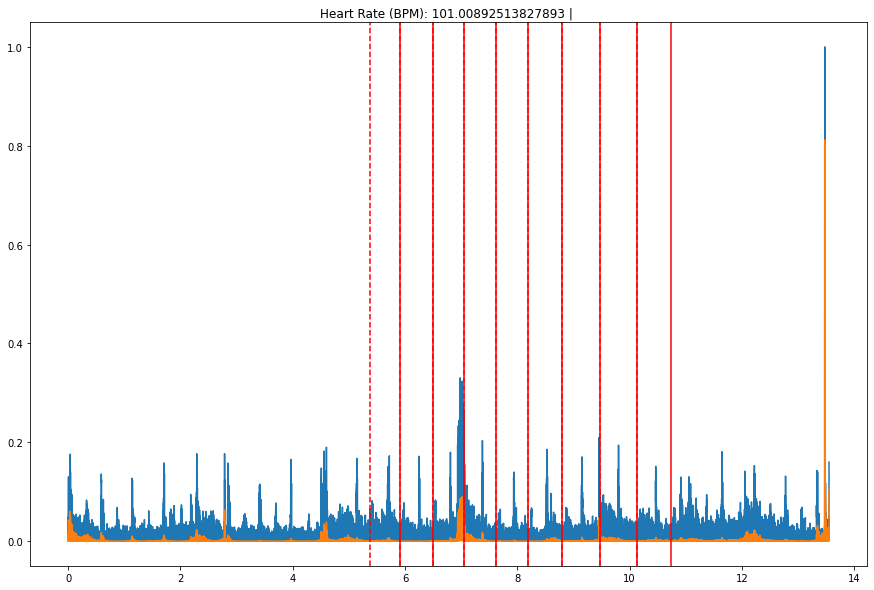

In [121]:
display_single_detail(details, "PV")

In [114]:
def my_filter(original_audio):
    
    mean = np.mean(original_audio)
    std = np.std(original_audio)
    
    return np.where(original_audio > (mean + 2 * std), original_audio, 0)
    

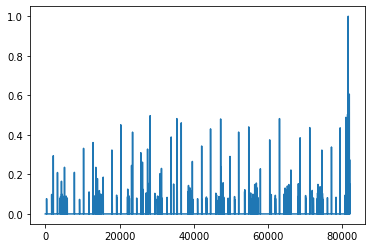

In [122]:
plt.plot( my_filter(sample) )
plt.show()

IPython.display.Audio(my_filter(sample), rate=4000)

In [62]:
signaltonoise(details["PV"]["audio"][0][0])

array(0.000609)

In [90]:
sample = details["PV"]["audio"][0][0]

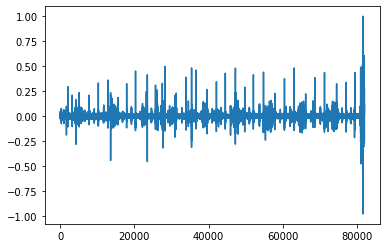

In [98]:
plt.plot(sample)
plt.show()

IPython.display.Audio(sample, rate=4000)

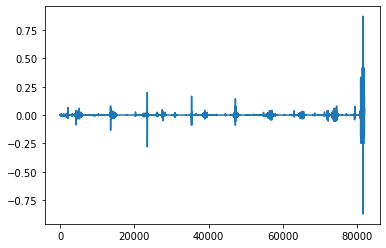

In [97]:
plt.plot(nr.reduce_noise(y=sample, sr=4000,  time_mask_smooth_ms=92))
plt.show()

IPython.display.Audio(nr.reduce_noise(y=sample, sr=4000,  time_mask_smooth_ms=64),  rate=4000)

In [124]:
f = np.fft.fft(sample)



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


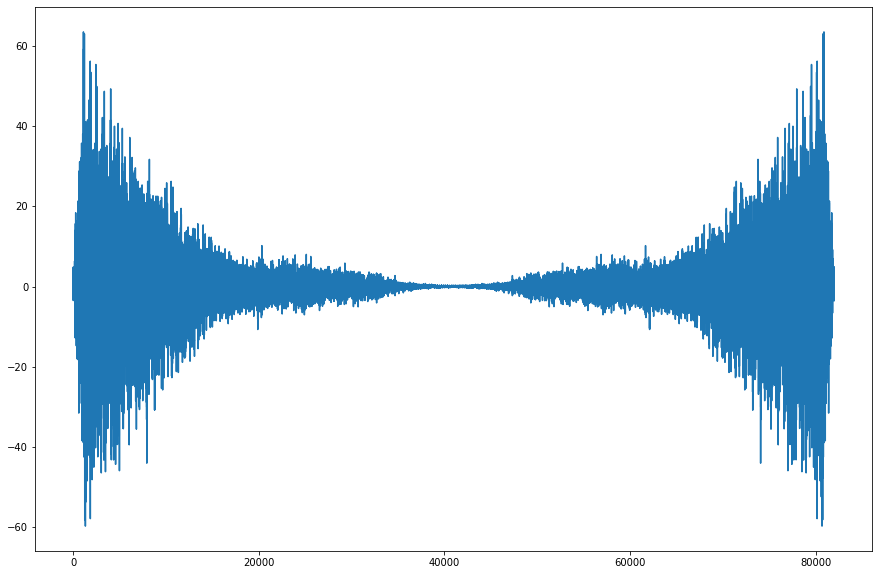

In [128]:
plt.figure(figsize=(15,10))
plt.plot(f)

In [135]:

def remove_high_frequencies(audio_data, sample_rate, cutoff_frequency):
    
    audio_fft = np.fft.fft(audio_data)
    fft_freqs = np.fft.fftfreq(len(audio_data), 1 / sample_rate)
    audio_fft[np.abs(fft_freqs) > cutoff_frequency] = 0
    modified_audio = np.fft.ifft(audio_fft)

    return modified_audio

# Example usage:
# Assuming audio_data is a NumPy array and sample_rate is the sample rate in Hz
modified_audio = remove_high_frequencies(audio_data, sample_rate, 5000)


NameError: name 'audio_data' is not defined

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


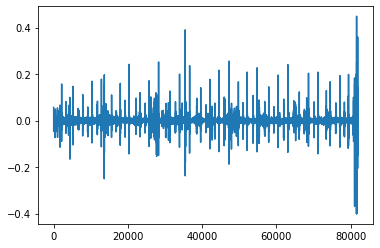

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/lib/display.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [144]:
plt.plot( remove_high_frequencies(sample, 4000, 200) )
plt.show()

IPython.display.Audio(remove_high_frequencies(sample, 4000, 200), rate=4000)

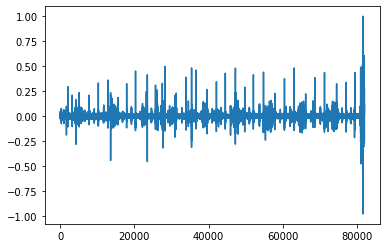

In [138]:
plt.plot(sample)